# Data wrangling Twitter data
In this notebook, we are going to start out with the raw Twitter data that was captured using the tool Tweepy on which you can read more about in another notebook. The data captured was restricted to tweets from Calgary from early November 2018. 

In order to prep the data for analysis, we will "wrangle" the data to clean it and structure it into a more useful format. 

## Goal: 
Learn some common aspects of data wrangling and convert the data set into a format more practical for further data exploration and analysis. 


## Data wrangling introduction
[Data wrangling](https://en.wikipedia.org/wiki/Data_wrangling) "is the process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics" (Wikipedia).

The purpose of data wrangling notebook is to transform complex data into a format that is easier to work with in order to focus on the analysis of data, rather than the wrangling in the next notebooks. 

#### Common data wrangling steps:
 - **Discovering**  - understanding the data
 - **Structuring** -  organizing the data
     - Naming or renaming variables
     - Changing the type of variables
     - Creating new variables through functions of existing of variables
     - Conditional processing of variables (i.e the values of new variable is based on the values of existing variables) 
 - **Cleaning** 
     - Redesign the data into a usable/functional format and correct/remove any bad data
     - Imputing missing values in a variables
 - **Publishing**
    - Selecting columns from input dataset to output dataset


## Load python modules

There are many packages available in Python that provide a variety of functions for data science. Here we load the libraries needed for this notebook. 

One of the most common libraries used for data science is [pandas](https://pandas.pydata.org/). There are good tutorials available on pandas and worthwhile spending more time with in order to become more comfortable with data science in python. 

In [2]:
try:
    import urllib.request
except ImportError:
    !pip install  --user urllib

try:
    import ast
except ImportError:
    !pip install  --user ast
    
try:
    import pandas as pd
except ImportError:
    !pip install  --user pandas

try:    
    import matplotlib.pyplot as plt
except ImportError:
    !pip install --user matplotlib
%matplotlib inline

## Step1. Taking a look at the raw data


#### Download the Twitter data from object store and display the first 5 rows

The raw data is stored in object storage. Here we download it from this storage platform and read it into a pandas DataFrame. A **DataFrame** is a commonly encountered way to work with data in data science. It can be thought of as a 2D data structure that makes it easy to work with the data at hand. 

In [11]:
target_url="https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/geeky-summit/tweets.txt"
file_name="tweets.txt"
urllib.request.urlretrieve(target_url, file_name)
tweets = []
with open(file_name, 'r') as f:
    for lines in f.readlines():
        tweets.append(ast.literal_eval(lines))
frame  = pd.DataFrame(tweets)
frame.head(3) # head is a convenient way for showing the first few rows of a dataframe

,coordinates,created_at,extended_tweet,hashtags,lang,name,screen_name,text,user_location,user_mentions
0,None,Fri Nov 02 21:01:56 +0000 2018,@Symin16 I’d like to know who,[],en,♠,jessmayumba85,@Symin16 I’d like to know who,Toronto ✈ Calgary,"[{'indices': [0, 8], 'id': 1031043960968364034..."
1,None,Fri Nov 02 21:02:01 +0000 2018,@TwoCanSamAdams Legit. There are still chunks ...,[],en,hannahrae cuddleslug,thimblewad,@TwoCanSamAdams Legit. There are still chunks ...,YYC,"[{'indices': [0, 15], 'id': 406677625, 'screen..."
2,"{'type': 'Point', 'coordinates': [-114.007914,...",Fri Nov 02 21:02:05 +0000 2018,Can you recommend anyone for this #job in #Cal...,"[{'indices': [34, 38], 'text': 'job'}, {'indic...",en,TMJ - CAL Manuf Jobs,tmj_cal_manuf,Can you recommend anyone for this #job in #Cal...,Calgary,[]


#### Understanding the raw data

Let's take a look at some basic features of the raw data. For example, it's always a good idea to look at the columnns and the size of the data in question. 

In [12]:
frame.columns

Index(['coordinates', 'created_at', 'extended_tweet', 'hashtags', 'lang',
       'name', 'screen_name', 'text', 'user_location', 'user_mentions'],
      dtype='object')

In [13]:
frame.shape

(14793, 10)

Taking a more complete look at the data, here the size of the DataFrame are printed, along with the: 
* column name
* column type
* sample value in the column

In [14]:
print("Number of rows/columns:",frame.shape, "\n")
for column in frame.columns:
    if column=="user_mentions":
        rownum=1
    else :
        rownum=2
    print("Column name: {colname} \nColumn type: {coltype} \nColumn data(example): {coldata} \n\n"
          .format(colname=column, coltype=type(frame[column].iloc[rownum]),coldata=frame[column].iloc[rownum]))

Number of rows/columns: (14793, 10) 

Column name: coordinates 
Column type: <class 'dict'> 
Column data(example): {'type': 'Point', 'coordinates': [-114.007914, 51.004583]} 


Column name: created_at 
Column type: <class 'str'> 
Column data(example): Fri Nov 02 21:02:05 +0000 2018 


Column name: extended_tweet 
Column type: <class 'str'> 
Column data(example): Can you recommend anyone for this #job in #Calgary, AB? https://t.co/20JiTB3cRi #SupplyChain #Hiring #CareerArc 


Column name: hashtags 
Column type: <class 'list'> 
Column data(example): [{'indices': [34, 38], 'text': 'job'}, {'indices': [42, 50], 'text': 'Calgary'}, {'indices': [80, 92], 'text': 'SupplyChain'}, {'indices': [93, 100], 'text': 'Hiring'}, {'indices': [101, 111], 'text': 'CareerArc'}] 


Column name: lang 
Column type: <class 'str'> 
Column data(example): en 


Column name: name 
Column type: <class 'str'> 
Column data(example): TMJ - CAL Manuf Jobs 


Column name: screen_name 
Column type: <class 'str'> 
Column

There are several interesting features there, such as latitude and longitude of the tweets and most of the columns make sense. Two columns that are a bit confusing are `text` and `extended_tweet` as it looks like they may contain the same content. We should figure out if they are actually different. 

One way to investigate this is to plot the length distribution for both columns. To do this, we use the [matplotlib library](https://matplotlib.org/) (another very common library used in data science). 

Text(0.5,0,'Tweet length')

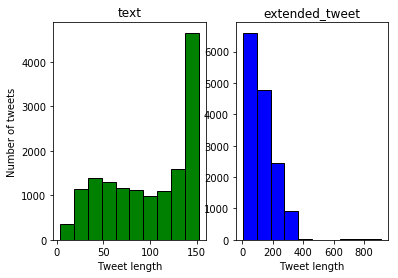

In [15]:
#Set up a plot with subplots (rows, columns, active plot)
plt.subplot(1, 2, 1) 
#Create a histogram, which counts the number of tweets of each length
plt.hist(frame["text"].apply(len).values, color = 'green' ,edgecolor = 'black')
#Label the plot
plt.title('text')
plt.xlabel('Tweet length')
plt.ylabel('Number of tweets')

# Do the same thing for the second subplot
plt.subplot(1, 2, 2)
plt.hist(frame["extended_tweet"].apply(len).values, color = 'blue', edgecolor = 'black')
plt.title('extended_tweet')
plt.xlabel('Tweet length')

Looks like `extended_tweet` has much longer tweets, up to 800 characters in length, whereas there are no tweets longer than 150 characters in `text`. 

What does the longest tweet look like. To do this, we can easily pull the longest tweet from the DataFrame. 


In [16]:
print("Maximum length for extended_tweet column: ",max(frame["extended_tweet"].apply(len)), "\n")

print("Tweet as seen in the **extended_text** column:\n")
print(frame["extended_tweet"][frame["extended_tweet"].apply(len).idxmax(axis=1)], "\n")

print("Tweet as seen in the **text** column:\n")
print(frame["text"][frame["extended_tweet"].apply(len).idxmax(axis=1)])

Maximum length for extended_tweet column:  913 

Tweet as seen in the **extended_text** column:

@erikwilson1975 @Plasticdoe @Vbalance03 @mcfunny @mimetic_ @BeckyJohnson222 @doritmi @EmmaGPaley @jkellyca @jpsportsminer @WendyOrent @ChrisJohnsonMD @Siubhan_H @amanda_pompili @MsTrixter @BlueLionBlog @Rosewind2007 @TinFoilAwards @jjfox123 @Awithonelison @seaglass34 @nicolasDenver @DansMonkeyShack @what_if_007 @StopVaxxedLies @regina1775 @GretchenScience @astrahlgems @Gattinov @jandtee @kidoctr @Takethatdoctors @djt10 @saluce65 @Just4TheCause @Microbedoc2 @cantab_biker @chrisvcsefalvay @xanthonejohn @Brian_Kitchener @SueQuez @carlsmythe @EbolaJuggler @PharmaNemesis @sarah_sxlxp @openmitochondro @ShooguhLipz @1002Loola @and_McDowell What is the deal with this flu strain. The original story was on a news service that interviewed a woman who had been sick as hell who had been told all the details by a Dr. Don't you "flushot doesn't work"ers think that some details could be wrong. SHE says get

It appears that text column is the truncated version of extended_tweet column.

#### So we have following list of columns:
 - **coordinates** - user coordinates, can be None or Python type Dict(needs to be split to two columns - longitude and latitude)
 - **created_at**  - creation date, Python type String (needs to be converted to type Date + timezone needs to be changed from UTC to MST)
 - **extended_tweet** - tweet text, Python type String
 - **hashtags** - hashtags, Python type List of Dicts(needs to be converted to String)
 - **lang** - language , Python type String
 - **name** - twitter account name, Python type String
 - **screen_name** - screen name, Python type String
 - **text** - truncated tweet text, Python type String
 - **user_location** - location, Python type String
 - **user_mentions** - user mentions, Python type List of Dicts(needs to be converted to String)

## Step 2. (Re-) structuring  the data

One aspect to always pay close attention to is the data type of each column. Overlooking data types and ending up with unexpected types often leads to issues further downstream in the analysis. Here we will go through and change some of the data types to make sure they are what we want them to be. 

As part of the process we will print original data example and converted data example. To get specific row/column from pandas datafram we will use following:
> datafarme_name["column_name"].iloc[row_number]

#### Convert column `created_at`  from String to Date and change timezone from UTC to MST

In [18]:
print(frame["created_at"].iloc[2]) ## Print the original data

frame["created_at_date"]= pd.to_datetime(frame["created_at"]) ## convert to timestamp
frame["created_at_date"]=frame["created_at_date"].dt.tz_localize('UTC').dt.tz_convert('America/Edmonton') ## fix timezone

print(frame["created_at_date"].iloc[2]) ## Print the transformed data

Fri Nov 02 21:02:05 +0000 2018
2018-11-02 15:02:05-06:00


#### Convert column "coordinates" from dictionary to two columns "latitude" and "longitude"

In [22]:
print(frame["coordinates"].head(), "\n") ## Print the original data

def convertCoordToList(v):  ## helper function
    if v is None:
        v=[]
    else:
        v= v['coordinates']
    return v

frame['coordinates_list']= frame['coordinates'].map(convertCoordToList) #Convert coordinates from Dict to List

#Split coordinates_list column into two: latitude and longitude
frame[['latitude','longitude']] = pd.DataFrame(frame['coordinates_list'].values.tolist())

print(frame[['longitude','latitude']].head()) ## Print the transformed data

0                                                 None
1                                                 None
2    {'type': 'Point', 'coordinates': [-114.007914,...
3                                                 None
4    {'type': 'Point', 'coordinates': [-114.0740046...
Name: coordinates, dtype: object 

   longitude    latitude
0        NaN         NaN
1        NaN         NaN
2  51.004583 -114.007914
3        NaN         NaN
4  50.997882 -114.074005


#### Convert column "hashtags"  from dictionary to strings
For the missing, will impute blanks.

In [21]:
print(frame["hashtags"].iloc[2]) ## Print the original data

def convertHashToString(v): ## helper function
    if v == []:
        v=' '
    else:
        v=' '.join([d['text'] for d in v])
    return v

frame['hashtags_string']= frame['hashtags'].map(convertHashToString) ## Do the conversion

print("\n",frame["hashtags_string"].iloc[2]) ## Print the transformed data

[{'indices': [34, 38], 'text': 'job'}, {'indices': [42, 50], 'text': 'Calgary'}, {'indices': [80, 92], 'text': 'SupplyChain'}, {'indices': [93, 100], 'text': 'Hiring'}, {'indices': [101, 111], 'text': 'CareerArc'}]

 job Calgary SupplyChain Hiring CareerArc


#### Exercise: convert column "user_mentions" from dictionary to string

Using the cell above as an example, complete the following cell in order to convert the `user_mentions` column to strings. 

In [25]:
print(frame["user_mentions"].iloc[1]) ## Print the original data + type
print(type(frame["user_mentions"].iloc[1]))

[{'indices': [0, 15], 'id': 406677625, 'screen_name': 'TwoCanSamAdams', 'id_str': '406677625', 'name': 'TwoCan Jorge'}]
<class 'list'>


In [27]:
def convertUserToString(v):
    if v == []:
        v=' '
    else:
        v=' '.join([d['screen_name'] for d in v])## type something here (this line will be hidden)
    return v

frame['user_string']= frame['user_mentions'].map(convertUserToString) ## Do the conversion 

#### Check yourself
Only screen_name's should be extracted from the distionary and data type should be str

In [29]:
print(frame["user_string"].iloc[1]) ## Print the transformed data + type
print(type(frame["user_string"].iloc[1]))

TwoCanSamAdams
<class 'str'>


## Step 3. Cleaning the data

Some data cleanup was done in step 2. Let's take a closer look at the `extended_tweet` column, since we will use it in further during our data analysis. 

First, let's look at what some of the tweets look like. We'll set an output parameter and then access the first few tweets. 

In [30]:
pd.set_option('max_colwidth', 700) ## Setting col_widht wider - so we can see the entire tweet
frame['extended_tweet'].head(10)

0                                                                                                                                                                                                                                                                                @Symin16 I’d like to know who
1                                                                                                                                  @TwoCanSamAdams Legit. There are still chunks in the sink and I can’t stand to be in the room, even though it doesn’t smell like puke anymore. I’m just so done with today.
2                                                                                                                                                                                              Can you recommend anyone for this #job in #Calgary, AB? https://t.co/20JiTB3cRi #SupplyChain #Hiring #CareerArc
3                                                                                          

####  Remove URLS 
There are lots of links in this column that might make our future data analysis messy and likely do not have any meaning. Let's remove them together with any links starting with www.  

We will accomplish this using regular expressions (Note that **\S+** means one or more non-whitespace character)

In [31]:
frame['extended_tweet']=frame['extended_tweet'].str.replace('http\S+|www.\S+', '', case=False)

#### Excersise: remove '\n' (new line symbol) from 'extended_tweet' column

Another item that might interfere with our analysis are new line characters. Let's remove these as well in the cell below. 

In [32]:
frame['extended_tweet']=frame['extended_tweet'].str.replace('\n',' ') ### this will be hidden

#### Check yourself
Print first 10 tweets and see if \n is removed

In [33]:
frame['extended_tweet'].head(10)

0                                                                                                                                                                                                                                                     @Symin16 I’d like to know who
1                                                                                                       @TwoCanSamAdams Legit. There are still chunks in the sink and I can’t stand to be in the room, even though it doesn’t smell like puke anymore. I’m just so done with today.
2                                                                                                                                                                                          Can you recommend anyone for this #job in #Calgary, AB?  #SupplyChain #Hiring #CareerArc
3                                                                                                                                                                           

#### Remove user mentions and hashtags from the 'extended_tweet' column and save it as 'extended_tweet_cleaned' column
There are separate columns for user mentions and hashtags. We might need to analyse tweet text without any hashtags/user mentions. However, we might also want to do some analysis on the tweets including the mentions and hashtags. As such, tweets with these items removed will be stored in a separate column. 

In [34]:
frame['extended_tweet_cleaned']=frame['extended_tweet'].str.replace('[@#]\w+', ' ',case=False)
frame['extended_tweet_cleaned'].head(5)

0                                                                                                                                             I’d like to know who
1      Legit. There are still chunks in the sink and I can’t stand to be in the room, even though it doesn’t smell like puke anymore. I’m just so done with today.
2                                                                                                             Can you recommend anyone for this   in  , AB?       
3                                                                                                                                Kids See Ghosts:  love this track
4                                                            See our latest  , AB   and click to apply: barista - Store# 54359, CHINOOK CENTRE FOOD COURT -       
Name: extended_tweet_cleaned, dtype: object

We will keep emoji, punctuation,  numbers and special characters for now. They might be useful for the analysis. We can always do more cleaning in the later notebooks

#### Let's take a look at the language column

In [36]:
frame["lang"].unique()

array(['en'], dtype=object)

Column lang has only one value en so it can be safely ignored



## Step 6. Publishing - saving data for future work

In order to work with this data further, let's save a new DataFrame. 

We'll simply select the desired columns from the working dataset into the output dataset and take a look at the output. Does the output match what we expected? How do the `extended_tweet` and `extended_tweet_clean` columns compare? 

Further below, we'll save the data to a csv file. 

In [37]:
frame_cleaned=frame[['created_at_date','hashtags_string','user_string','user_location',
                     'longitude','latitude','name', 'screen_name','extended_tweet','extended_tweet_cleaned']]
frame_cleaned.head()

,created_at_date,hashtags_string,user_string,user_location,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned
0,2018-11-02 15:01:56-06:00,,Symin16,Toronto ✈ Calgary,NaN,NaN,♠,jessmayumba85,@Symin16 I’d like to know who,I’d like to know who
1,2018-11-02 15:02:01-06:00,,TwoCanSamAdams,YYC,NaN,NaN,hannahrae cuddleslug,thimblewad,"@TwoCanSamAdams Legit. There are still chunks in the sink and I can’t stand to be in the room, even though it doesn’t smell like puke anymore. I’m just so done with today.","Legit. There are still chunks in the sink and I can’t stand to be in the room, even though it doesn’t smell like puke anymore. I’m just so done with today."
2,2018-11-02 15:02:05-06:00,job Calgary SupplyChain Hiring CareerArc,,Calgary,51.004583,-114.007914,TMJ - CAL Manuf Jobs,tmj_cal_manuf,"Can you recommend anyone for this #job in #Calgary, AB? #SupplyChain #Hiring #CareerArc","Can you recommend anyone for this in , AB?"
3,2018-11-02 15:02:10-06:00,,,🌎📱,NaN,NaN,Sunny Rai,TheSunsRay,Kids See Ghosts: love this track,Kids See Ghosts: love this track
4,2018-11-02 15:02:13-06:00,Calgary job,,Calgary,50.997882,-114.074005,TMJ-CAL Retail Jobs,tmj_cal_retail,"See our latest #Calgary, AB #job and click to apply: barista - Store# 54359, CHINOOK CENTRE FOOD COURT - #Retail #Hiring #CareerArc","See our latest , AB and click to apply: barista - Store# 54359, CHINOOK CENTRE FOOD COURT -"


In [38]:
frame_cleaned.to_csv('tweets_cleaned.csv',index=False)

##  Conclusion

We've taken a preliminary look at some of the raw Twitter data that's been collected in order to further work with it. This included restructuring and reorganizing it and cleaning up the columns that we anticipate needing the most for our analysis.

Take-aways: 
* We've started working with some very popular libraries for doing data science in Python: pandas and matplotlib
* Examining, wrangling, and cleaning your data are important work that will take up large portions of time in the data science workflow
* This is an iterative process. We took a stab at what we need to clean up and refine now, but may very well find things we've missed as we dig deeper into the data. 

Next, we will get into data exploration further. 